# Self-synteny for WGD detection

If a whole-genome duplication (WGD) has happened in a lineage, we would expect to see at least some corresponding chromosomes that carry multiple paralogous genes. Therefore, if we perform an all-against-all search with protein sequences, set a relatively high e-value threshold (e.g. $10^{-10}$ or $10^{-20}$) and exclude self-hits (i.e. search for paralogs), we should be able to see a pattern. If WGD has taken place, we should be seeing many clustered off-diagonal hits, linking the two paralogous chromosomes. However, if all that is seen is a random scatter of hits, then it is likely that no WGD has occurred.

used this list to scan against the _P. litorale_ draft genome using `mmseqs`:

<font color="red">TODO:</font>


```bash
cd /lisc/scratch/zoology/pycnogonum/genome/draft/self_synteny
module load mmseqs2
M8FORMAT="query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qlen"
proteome=/lisc/scratch/zoology/pycnogonum/genome/draft/transcripts.fa.transdecoder.pep
mmseqs easy-search $proteome $proteome self.m8 tmp --format-output $M8FORMAT --threads 16 --cov-mode 5 -c 0.8
```

In [1]:
from tqdm import tqdm

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [2]:
def read_gff(loc):
    gff = pd.read_csv(loc, sep="\t", header=None, skiprows=4)
    gff_columns = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    gff.columns = gff_columns
    return gff

# read file, name columns
def read_aln(m8, id_sep=None):
    plit = pd.read_csv(m8, sep="\t", header=None)
    m8_columns = ['query', 'target', 'seq_id', 'ali_len', 'no_mism', 'no_go',
                'q_start', 'q_end', 't_start', 't_end', 'eval', 'bit', 'qlen']
    plit.columns = m8_columns
    # trim the query to just the ID
    if id_sep is not None:
        plit["query"] = plit["query"].str.split(id_sep).str[1]
    return plit

def get_contig_lengths(fasta):
    lengths = {}
    with open(fasta, "r") as fh:
        for line in fh:
            if line.startswith(">"):
                contig = line.strip().split()[0].replace(">", "")
                lengths[contig] = 0
            else:
                lengths[contig] += len(line.strip())
    return lengths

In [3]:
gff_loc = "/Volumes/project/pycnogonum/paper/zenodo/results/merged_sorted_named_dedup_flagged.gff3"
fasta_loc = "/Volumes/project/pycnogonum/paper/zenodo/results/draft.fasta"

tmp = read_gff(gff_loc)
gff = tmp[tmp['type'] == 'gene'].copy()
gff['gene'] = gff['attributes'].str.split("ID=").str[1].str.split(";").str[0]
gff['gene'] = gff['gene'].str.split(',').str[0]
gff.set_index("gene", inplace=True)
del tmp

contigs = get_contig_lengths(fasta_loc)

In [4]:
plit = read_aln('/Volumes/scratch/pycnogonum/genome/draft/self_synteny/self.m8')

In [5]:
def extract_gene_name(x):
    if x.startswith("PB"):
        return ".".join(x.split(".")[0:2]).split(',')[0]
    elif x.startswith("g"):
        return x.split(".")[0]
    elif x.startswith("r2"):
        return x.split(".")[0]
    elif x.startswith("at"):
        return x.split(".")[0]
    else:
        return None

In [6]:
plit['gene_from'] = plit['query'].apply(extract_gene_name)
plit['gene_to'] = plit['target'].apply(extract_gene_name)

remove = plit['gene_from'] == plit['gene_to']

In [7]:
best = plit[~remove].groupby(['gene_from', 'gene_to'])['eval'].min().reset_index()

In [8]:
chromosomes = {x: contigs[x] for x in contigs.keys() if x.startswith("pseudochrom")}

offsets = {}
offsets["pseudochrom_1"] = 0

for i in np.arange(2, 58):
    offsets[f"pseudochrom_{i}"] = 0
    for j in np.arange(1, i):
        offsets[f"pseudochrom_{i}"] += contigs[f"pseudochrom_{j}"]

In [9]:
def add_point(row, gff, offsets, ax):
    gene_from = row['gene_from']
    gene_to = row['gene_to']

    # get the chromosome for each gene
    chrom_from = gff['seqid'].loc[gene_from]
    chrom_to = gff['seqid'].loc[gene_to]

    # if either gene is on a scaffold, skip, we are not plotting those
    if chrom_from.startswith('scaffold') or chrom_to.startswith('scaffold'):
        return
    # if the genes are on the same chromosome, color them differently
    if chrom_from == chrom_to:
        col = 'red'
    else:
        col = 'black'
    
    # get the middle of each gene
    start_from = gff['start'].loc[gene_from]
    end_from = gff['end'].loc[gene_from]
    loc_from = (start_from + end_from) / 2

    start_to = gff['start'].loc[gene_to]
    end_to = gff['end'].loc[gene_to]
    loc_to = (start_to + end_to) / 2

    # get the offset for each gene
    offset_from = offsets[chrom_from]
    offset_to = offsets[chrom_to]

    # plot the points
    y = loc_from + offset_from
    x = loc_to + offset_to

    # print(row['gene_from'], row['gene_to'], x, y)
    ax.plot(x, y, 'o', color=col, markersize=1)

In [10]:
total_length = sum([x for x in chromosomes.values()])

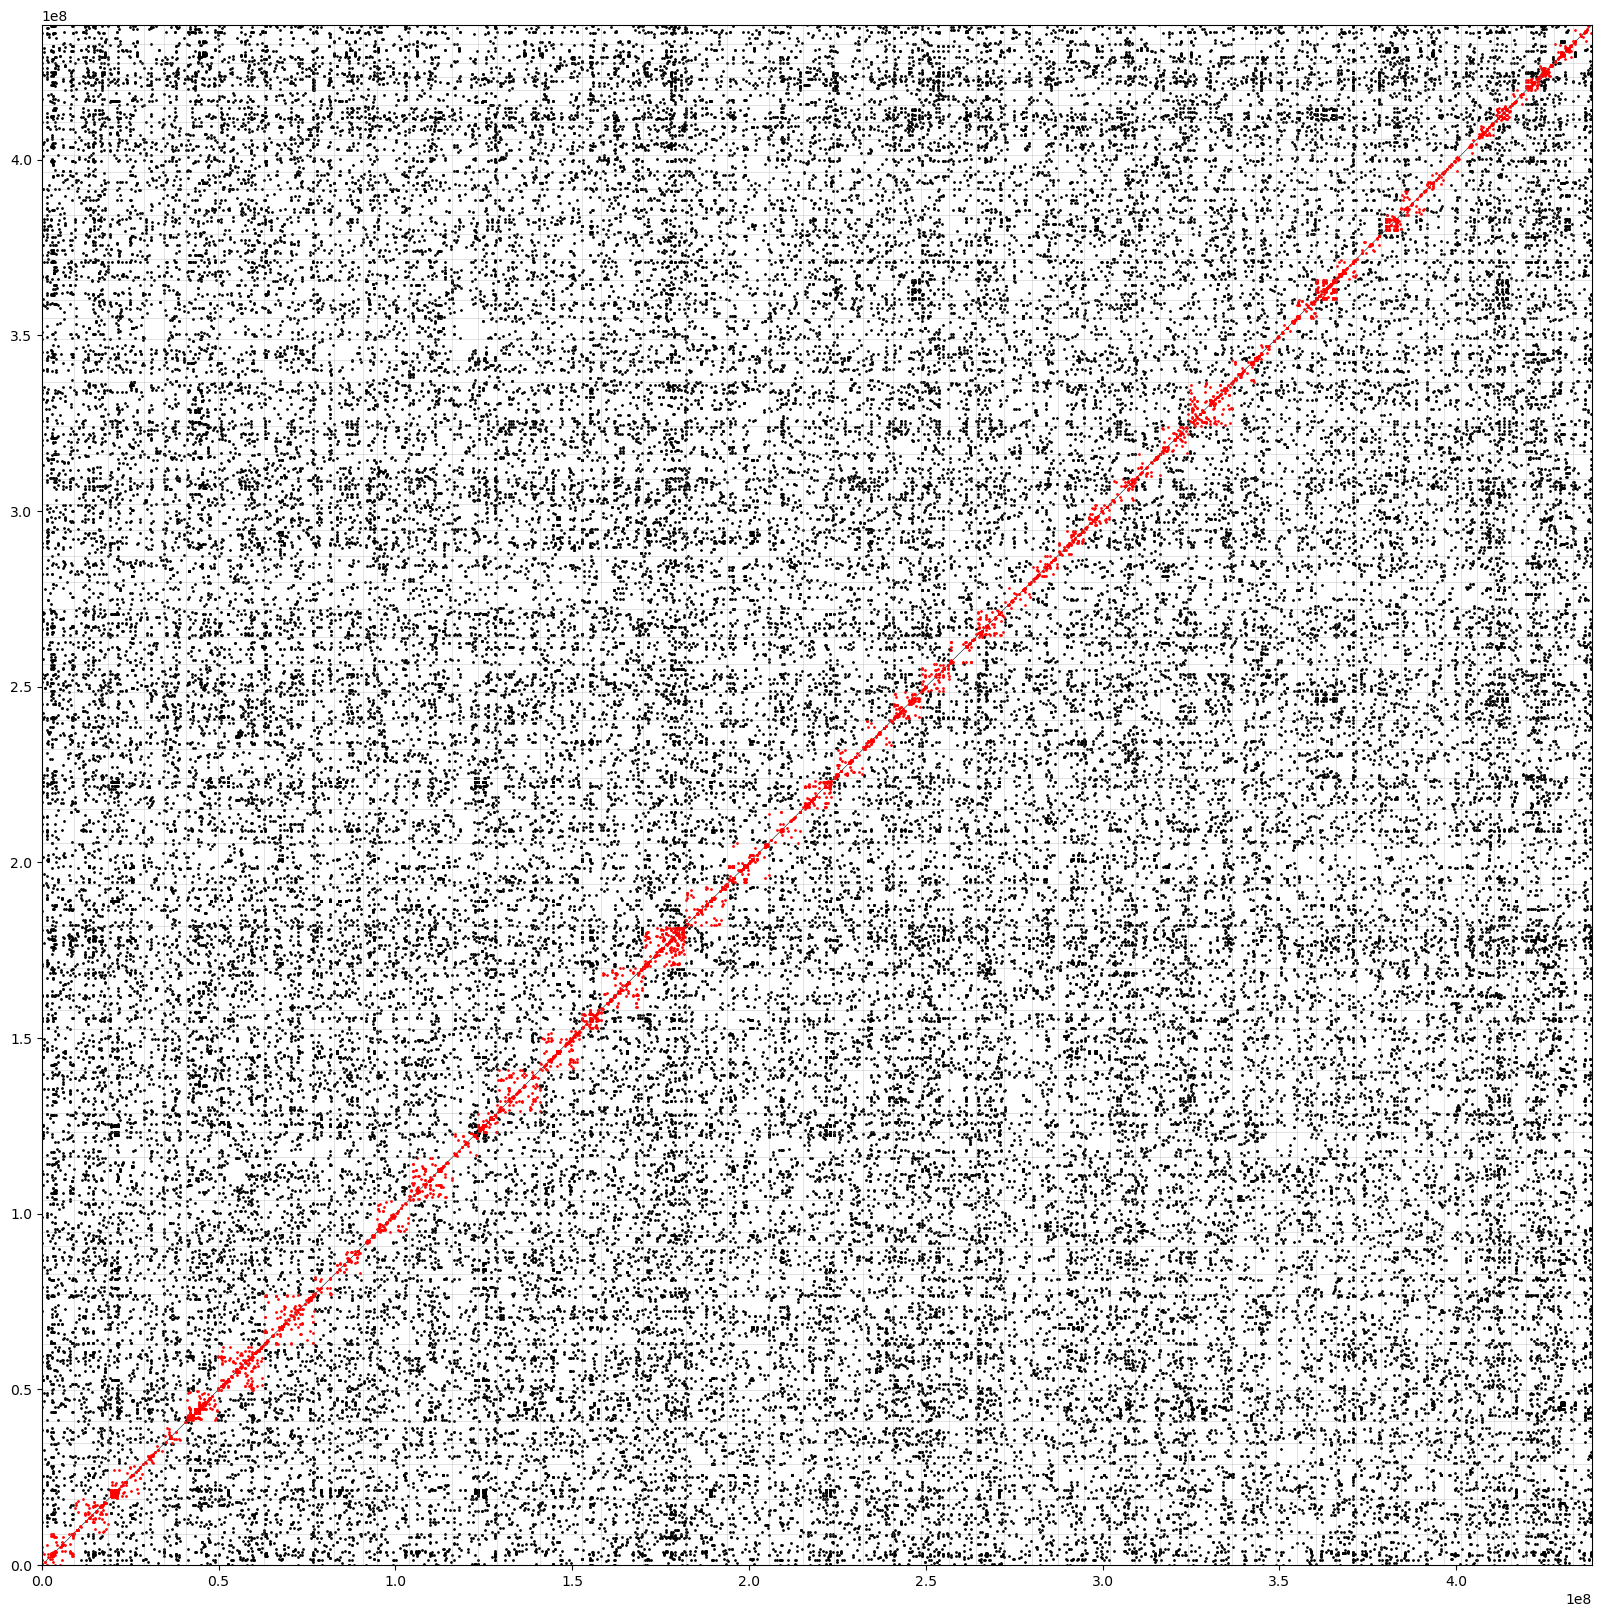

In [11]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_xlim(0, total_length)
ax.set_ylim(0, total_length)
# ax.set_xticks([offsets[x]+chromosomes[x]/2 for x in chromosomes.keys()])
# ax.set_xticklabels([x.split('_')[1] for x in chromosomes.keys()])

# ax.set_yticks([offsets[x]+chromosomes[x]/2 for x in chromosomes.keys()])
# ax.set_yticklabels([x.split('_')[1] for x in chromosomes.keys()])

ax.plot([0, total_length], [0, total_length], color='black', linestyle='-', linewidth=0.4)

for _, hit in best.iterrows():
    add_point(hit, gff, offsets, ax)

for _, offset in offsets.items():
    ax.axvline(offset, color='gray', alpha=0.4, linewidth=0.4)
    ax.axhline(offset, color='gray', alpha=0.4, linewidth=0.4)